In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import atac_model.profile_models as profile_models
import atac_model.profile_performance as profile_performance
import atac_model.train_profile_model as train_profile_model
import feature.util as feature_util
import atac_model.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm

### Define paths for the model and data of interest

In [9]:
# Define the paths to the files and model, and some constants
base_path = "/users/amtseng/test/atac_tracks/ENCSR220ASC"                   
peak_beds = [os.path.join(base_path, item) for item in [                    
    "rep1_peaks_ENCFF550DRF.bed.gz",                                        
    "rep2_peaks_ENCFF348ZZP.bed.gz",                                        
    "rep3_peaks_ENCFF801YCD.bed.gz"                                         
]]                                                                          
profile_hdf5 = os.path.join(base_path, "profiles.hdf5")
peaks_bed = peak_beds[0]

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

In [3]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [65]:
# Import the model without priors
model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/ATAC/A549_prior/1/model_ckpt_epoch_6.pt"
model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, model_path)
model.eval()
model = model.to(device) 

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [7]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

### Predicting and plotting profiles

In [10]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

In [24]:
def predict_coords(model, coords, att_prior_pos_limit=160):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset, and
    the input gradients. The returned profiles are in terms of raw counts, and the
    returned counts are also raw. Returned values are all NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    true_profs = model_util.place_tensor(torch.tensor(profiles)).float()

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_profs, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_profs.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    input_seqs_np = input_seqs.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    status = model_util.place_tensor(torch.ones(input_seqs.size()[0]))
    loss, (corr_loss, att_loss), (prof_loss, count_loss) = \
        train_profile_model.model_loss(
            model, true_profs, logit_pred_profs, log_pred_counts, 0, 20, 50,
            None, 1, 3, "fourier", 160, None, False,
            input_grads, status, None
    )
    print("Profile loss\tCounts loss\tPrior loss")
    print("%6.3f\t%6.3f\t%6.3f" % (
        prof_loss.item(), count_loss.item(), att_loss.item(),
    ))
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_seqs_np, input_grads_np

In [16]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length = pred_profs.shape
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 2))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i], color="royalblue", alpha=0.5)
        ax[i].plot(pred_profs[i], color="darkslateblue")
    if title:
        fig.suptitle(title)

### Computing/plotting Fourier transforms

In [17]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [18]:
def plot_grad_and_fft(input_grad, input_seq, include_dc=False, pos_limit=None):
    assert len(input_grad.shape) == 2
    assert len(input_seq.shape) == 2
    
    grad_x_seq = np.sum(input_grad * input_seq, axis=1)
    abs_grad = np.abs(grad_x_seq)
    freqs, mags = dft(abs_grad)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, absolute value, and the DFT
    fig, ax = plt.subplots(3, 1, figsize=(20, 10))
    ax[0].plot(grad_x_seq)
    ax[0].set_title("Input gradient * input sequence")
    ax[0].margins(0)
    ax[1].plot(abs_grad)
    ax[1].set_title("|Input gradient * input sequence|")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(grad_x_seq)
        ax[2].axvline(x=pos_limit_radians, color="black")
    ax[2].margins(0)
    fig.tight_layout()

### View predictions

In [27]:
def predict_and_plot(model, chrom, start, end, viz_slice=slice(600, 700)):
    log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs, input_grads = \
        predict_coords(model, [(chrom, start, end)] * 50, att_prior_pos_limit=160)

    pred_prof_probs = np.exp(log_pred_profs)
    true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
    plot_profiles(pred_prof_probs[0], true_prof_probs[0])

    plot_grad_and_fft(input_grads[0], input_seqs[0], pos_limit=160)
    viz_sequence.plot_weights(input_grads[0][viz_slice])
    viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[viz_slice])

In [29]:
pos_coords_table.sample(5)

,0,1,2,3,4,5,6,7,8,9
55382,chr7,2364892,2365156,atacseq_170613.t0_rep1.dedup.masked.sorted_pea...,100,.,5.85106,12.49423,10.01817,107
32848,chr2,20962976,20963285,atacseq_170613.t0_rep1.dedup.masked.sorted_pea...,65,.,4.42478,8.90508,6.58095,164
5917,chr1,241658046,241658246,atacseq_170613.t0_rep1.dedup.masked.sorted_pea...,38,.,4.08982,6.01348,3.83810,108
27878,chr17,77449939,77450147,atacseq_170613.t0_rep1.dedup.masked.sorted_pea...,22,.,2.65625,4.29447,2.25095,71
59625,chr8,28385900,28386866,atacseq_170613.t0_rep1.dedup.masked.sorted_pea...,266,.,7.34463,29.73138,26.69077,283


Profile loss	Counts loss	Prior loss
37239.812	 1.868	 0.099


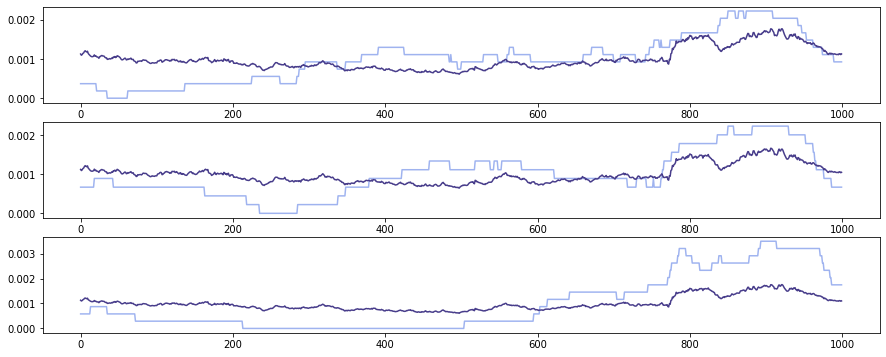

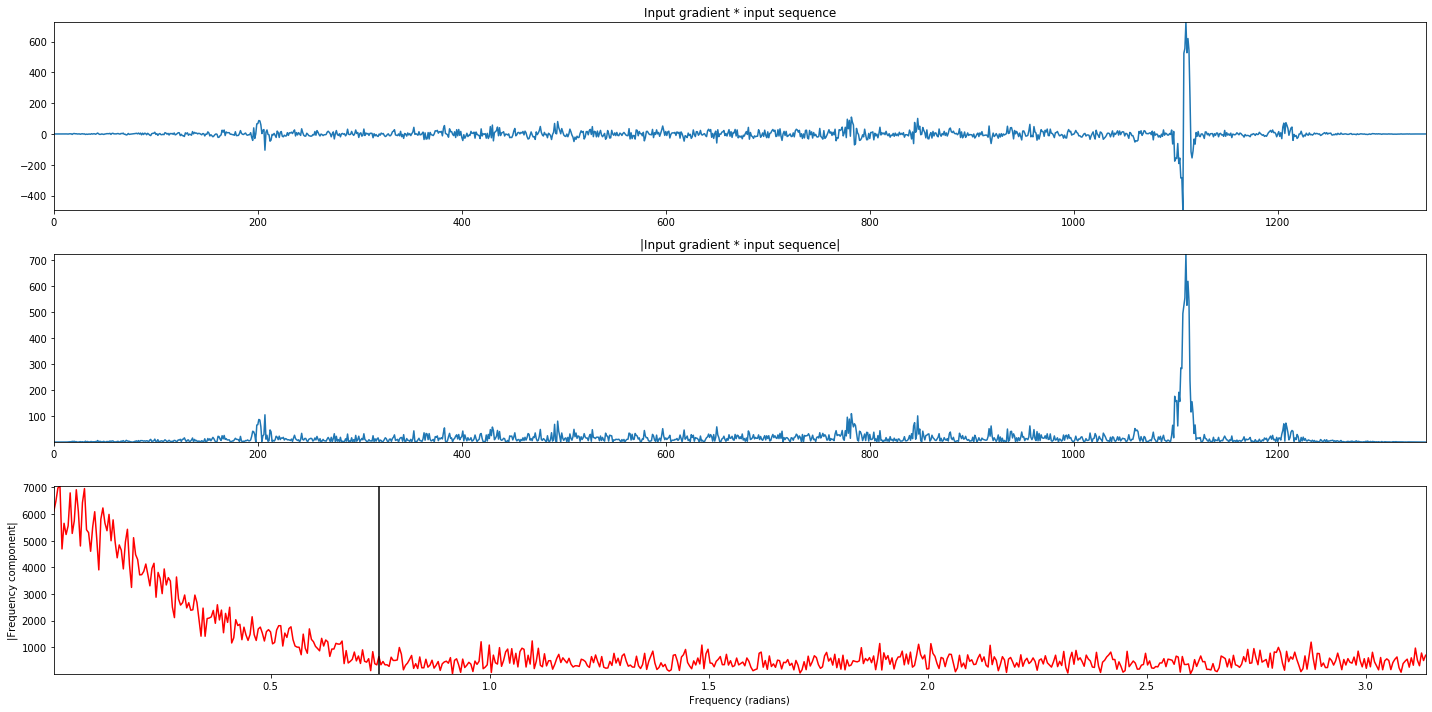

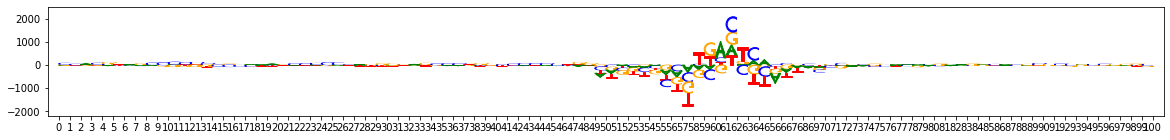

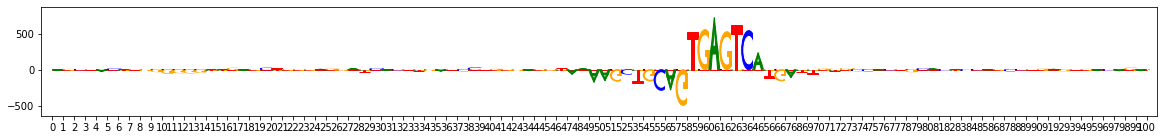

In [69]:
chrom, start, end = "chr1", 241658046, 241658246
predict_and_plot(model, chrom, start, end, viz_slice=slice(1050, 1150))

Profile loss	Counts loss	Prior loss
27161.625	 0.542	 0.201


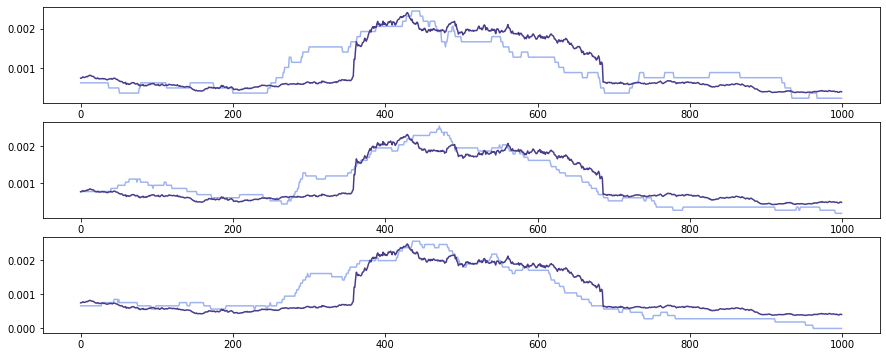

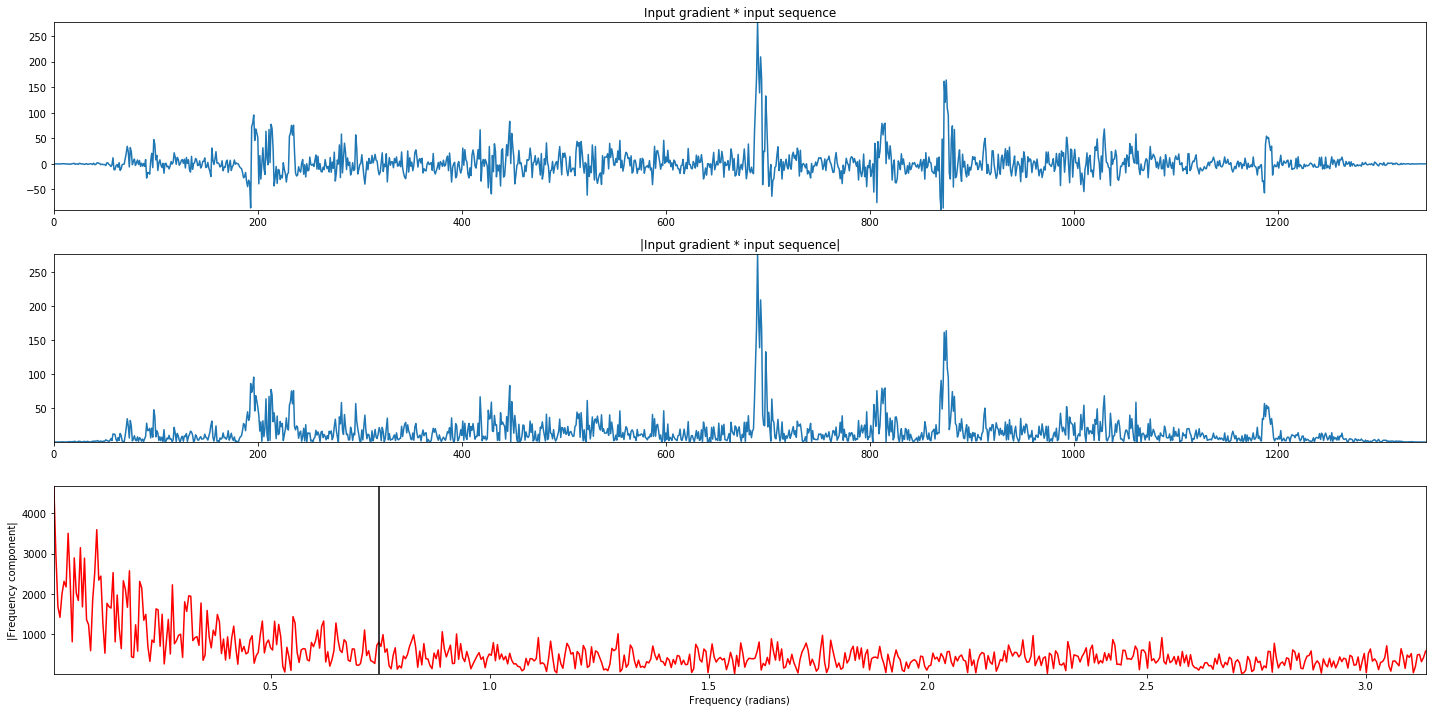

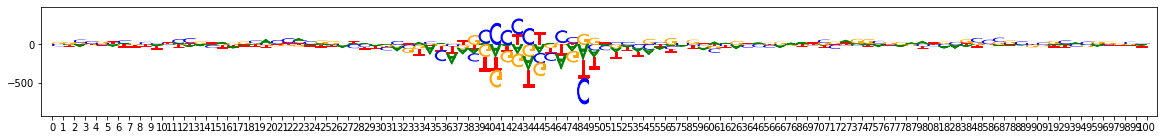

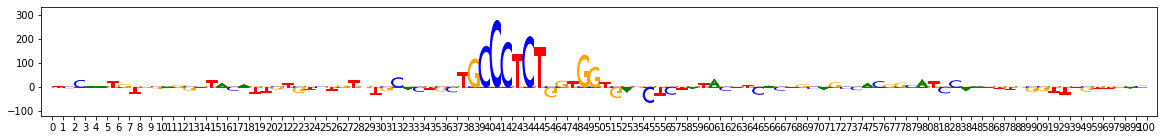

In [67]:
chrom, start, end = "chr2", 20962976, 20963285
predict_and_plot(model, chrom, start, end, viz_slice=slice(650, 750))